In [1]:
!gdown 1xYkt31U9I2JJiwSCaJ2q_pcrnFzDWORJ
!unzip moreplus.zip -d MorePLUS

Downloading...
From (original): https://drive.google.com/uc?id=1xYkt31U9I2JJiwSCaJ2q_pcrnFzDWORJ
From (redirected): https://drive.google.com/uc?id=1xYkt31U9I2JJiwSCaJ2q_pcrnFzDWORJ&confirm=t&uuid=b553610c-e927-4bb8-aee1-461a82e8b4a5
To: /kaggle/working/moreplus.zip
100%|████████████████████████████████████████| 385M/385M [00:04<00:00, 87.8MB/s]
Archive:  moreplus.zip
   creating: MorePLUS/images/
  inflating: MorePLUS/D_train.pkl    
  inflating: MorePLUS/D_val.pkl      
  inflating: MorePLUS/O_train.pkl    
  inflating: MorePLUS/O_val.pkl      
  inflating: MorePLUS/train_df.tsv   
  inflating: MorePLUS/val_df.tsv     
  inflating: MorePLUS/images/1002982898342944991_1198605375.jpg  
  inflating: MorePLUS/images/933477935272558592.jpg  
  inflating: MorePLUS/images/1016906996764044641_49448770.jpg  
  inflating: MorePLUS/images/849628192944074752.jpg  
  inflating: MorePLUS/images/884812025532002304.jpg  
  inflating: MorePLUS/images/878660961099550723.jpg  
  inflating: MorePLUS/imag

In [2]:
!pip install rouge_score
!pip install --upgrade nltk
!pip install bert_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=24db571f06ab6be461602fb4ac26715c5b2fe368224fec1ef433f3ade6b55af9
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.8 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.3 MB/s eta 0:00:00


In [3]:
import torch
import os
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BartTokenizer,
    BartForConditionalGeneration,
    ViTFeatureExtractor,
    ViTModel,
    BartConfig,
    ViTConfig,
    modeling_outputs,
)
from transformers.modeling_outputs import BaseModelOutput
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
import bert_score
import warnings

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
d_train = "/kaggle/working/MorePLUS/D_train.pkl"
o_train = "/kaggle/working/MorePLUS/O_train.pkl"
df_train = "/kaggle/working/MorePLUS/train_df.tsv"
d_val = "/kaggle/working/MorePLUS/D_val.pkl"
o_val = "/kaggle/working/MorePLUS/O_val.pkl"
df_val = "/kaggle/working/MorePLUS/val_df.tsv"
image_dir = "/kaggle/working/MorePLUS/images"
warnings.filterwarnings("ignore")

with open(d_train, "rb") as f:
    d_train = pickle.load(f)
with open(o_train, "rb") as f:
    o_train = pickle.load(f)
with open(d_val, "rb") as f:
    d_val = pickle.load(f)
with open(o_val, "rb") as f:
    o_val = pickle.load(f)

df_train = pd.read_csv(df_train, sep = "\t")
df_val = pd.read_csv(df_val, sep = "\t")

In [5]:
class MOREPDataset(Dataset):
    def __init__(self, dataframe, image_dir, d_pkl, o_pkl):
        self.df = dataframe
        self.image_dir = image_dir
        self.image_descriptions = d_pkl
        self.detected_objects = o_pkl

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        pid, text, explanation, target = row['pid'], row['text'], row['explanation'], row['target_of_sarcasm']

        image_path = f"{self.image_dir}/{pid}.jpg"
        image = Image.open(image_path).convert('RGB')

        object_text = self.detected_objects.get(pid, {"classes":[]})["classes"]
        object_text = " ".join(object_text) if object_text else ""
        description_text = self.image_descriptions.get(pid, "")
        
        return {
            'text': text,
            'target': target,
            'objects': object_text,
            'description': description_text,
            'explanation': explanation,
            'image': image
        }

def collate_fn(batch):
    collated = {
        'text': [item['text'] for item in batch],
        'target': [item['target'] for item in batch],
        'objects': [item['objects'] for item in batch],
        'description': [item['description'] for item in batch],
        'explanation': [item['explanation'] for item in batch],
        'image': [item['image'] for item in batch],
    }
    return collated

In [6]:
class MYTURBOModel(nn.Module):
    def __init__(self,
                 bart_model="facebook/bart-base",
                 vit_model="google/vit-base-patch16-224",
                 num_attn_heads=8,
                 dropout_rate=0.2,
                 device=None):
        super(MYTURBOModel, self).__init__()

        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = device

        self.tokenizer = BartTokenizer.from_pretrained(bart_model)
        self.feature_extractor = ViTFeatureExtractor.from_pretrained(vit_model)

        self.bart = BartForConditionalGeneration.from_pretrained(bart_model)
        self.vit = ViTModel.from_pretrained(vit_model)

        vit_hidden_size = self.vit.config.hidden_size
        bart_hidden_size = self.bart.config.d_model

        self.dropout = nn.Dropout(dropout_rate)

        self.vit_proj = nn.Linear(vit_hidden_size, bart_hidden_size)

        self.modality_type_embeddings = nn.Embedding(6, bart_hidden_size)

        encoder_layer_v = nn.TransformerEncoderLayer(
            d_model=bart_hidden_size,
            nhead=num_attn_heads,
            dim_feedforward=bart_hidden_size * 4,
            dropout=dropout_rate,
            activation='relu',
            batch_first=True,
            device=self.device
        )
        self.self_attn_v = nn.TransformerEncoder(encoder_layer_v, num_layers=1)

        encoder_layer_t = nn.TransformerEncoderLayer(
            d_model=bart_hidden_size,
            nhead=num_attn_heads,
            dim_feedforward=bart_hidden_size * 4,
            dropout=dropout_rate,
            activation='relu',
            batch_first=True,
            device=self.device
        )
        self.self_attn_t = nn.TransformerEncoder(encoder_layer_t, num_layers=1)

        self.cross_attn_vt = nn.MultiheadAttention(
            embed_dim=bart_hidden_size,
            num_heads=num_attn_heads,
            dropout=dropout_rate,
            batch_first=True,
            device=self.device
        )
        self.cross_attn_tv = nn.MultiheadAttention(
            embed_dim=bart_hidden_size,
            num_heads=num_attn_heads,
            dropout=dropout_rate,
            batch_first=True,
            device=self.device
        )

        self.norm_v1 = nn.LayerNorm(bart_hidden_size, device=self.device)
        self.norm_t1 = nn.LayerNorm(bart_hidden_size, device=self.device)
        self.norm_v2 = nn.LayerNorm(bart_hidden_size, device=self.device)
        self.norm_t2 = nn.LayerNorm(bart_hidden_size, device=self.device)


        self.gate_v_linear = nn.Linear(bart_hidden_size, bart_hidden_size)
        self.gate_t_linear = nn.Linear(bart_hidden_size, bart_hidden_size)

        self.alpha1 = nn.Parameter(torch.tensor(1.0))
        self.alpha2 = nn.Parameter(torch.tensor(1.0))
        self.beta1 = nn.Parameter(torch.tensor(1.0))
        self.beta2 = nn.Parameter(torch.tensor(1.0))

        self.vit_proj.to(self.device)
        self.modality_type_embeddings.to(self.device)
        self.gate_v_linear.to(self.device)
        self.gate_t_linear.to(self.device)


    def encode_text(self, text_list):
        inputs = self.tokenizer(
            text_list,
            padding='longest',
            truncation=True,
            return_tensors="pt",
            max_length=512
        ).to(self.device)
        if inputs.input_ids.numel() == 0:
            warnings.warn("Empty input_ids generated by tokenizer, returning zeros.")
            batch_size = len(text_list) if isinstance(text_list, list) else 1
            return torch.zeros((batch_size, 1, self.bart.config.d_model), device=self.device)

        outputs = self.bart.model.encoder(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask']
        )
        return self.dropout(outputs.last_hidden_state)

    def _apply_attention_and_fusion(self, E_v, E_t):
        """
        Applies self-attention, cross-attention, pooling, and gated fusion.
        Args:
            E_v (torch.Tensor): Initial Visual embeddings (B, SeqLen_v, D)
            E_t (torch.Tensor): Initial Textual embeddings (B, SeqLen_t, D)
        Returns:
            torch.Tensor: Fused representation (B, D)
        """
        E_v_pool_orig = E_v.mean(dim=1)
        E_t_pool_orig = E_t.mean(dim=1)

        sa_v = self.self_attn_v(E_v)
        sa_t = self.self_attn_t(E_t)

        A_v = self.norm_v1(E_v + self.dropout(sa_v))
        A_t = self.norm_t1(E_t + self.dropout(sa_t))

        ca_vt, _ = self.cross_attn_vt(query=A_v, key=A_t, value=A_t)
        ca_tv, _ = self.cross_attn_tv(query=A_t, key=A_v, value=A_v)

        X_vt = self.norm_v2(A_v + self.dropout(ca_vt))
        X_tv = self.norm_t2(A_t + self.dropout(ca_tv))

        X_vt_pool = X_vt.mean(dim=1) # Shape: (B, D)
        X_tv_pool = X_tv.mean(dim=1) # Shape: (B, D)

        G_v_pool = torch.sigmoid(self.gate_v_linear(X_vt_pool))
        G_t_pool = torch.sigmoid(self.gate_t_linear(X_tv_pool))

        F1 = (G_v_pool * X_tv_pool) + ((1 - G_v_pool) * X_vt_pool)
        F2 = (G_t_pool * X_tv_pool) + ((1 - G_t_pool) * X_vt_pool)

        Fv = (G_v_pool * E_v_pool_orig) + ((1 - G_v_pool) * X_tv_pool)
        Ft = (G_t_pool * E_t_pool_orig) + ((1 - G_t_pool) * X_vt_pool)

        weights = torch.softmax(torch.stack([self.alpha1, self.alpha2, self.beta1, self.beta2]), dim=0)
        F_SF_pool = (weights[0] * self.dropout(F1) +
                     weights[1] * self.dropout(F2) +
                     weights[2] * self.dropout(Fv) +
                     weights[3] * self.dropout(Ft))


        return F_SF_pool


    def _prepare_inputs(self, batch):
        """ Encodes inputs, adds modality tokens """
        images_data = batch.get('image', batch.get('images'))

        inputs = self.feature_extractor(images=images_data, return_tensors="pt", padding=True)
        pixel_values = inputs.pixel_values.to(self.device)

        self.vit.to(self.device)
        vit_out = self.vit(pixel_values=pixel_values).last_hidden_state
        vit_proj = self.dropout(self.vit_proj(vit_out))

        text_emb = self.encode_text(batch['text'])
        obj_emb = self.encode_text(batch['objects'])
        desc_emb = self.encode_text(batch['description'])
        tgt_emb = self.encode_text(batch['target'])

        B = vit_proj.size(0)

        def add_modality_tokens(x, token_id):
            type_ids = torch.full((x.size(1),), token_id, dtype=torch.long, device=x.device)
            type_ids = type_ids.unsqueeze(0).expand(B, -1)
            return self.dropout(x + self.modality_type_embeddings(type_ids))

        text_emb = add_modality_tokens(text_emb, 0)
        obj_emb = add_modality_tokens(obj_emb, 1)
        desc_emb = add_modality_tokens(desc_emb, 2)
        tgt_emb = add_modality_tokens(tgt_emb, 3)
        vit_proj = add_modality_tokens(vit_proj, 4)

        E_t_combined = torch.cat([text_emb, obj_emb, desc_emb, tgt_emb], dim=1)

        return vit_proj, E_t_combined


    def forward(self, batch):
        E_v, E_t = self._prepare_inputs(batch)

        fused_pooled_representation = self._apply_attention_and_fusion(E_v, E_t)

        explanation_text = batch.get('explanation', batch.get('explanations'))
        if explanation_text is None:
            raise ValueError("Batch must contain 'explanation' or 'explanations' key.")

        explanation_inputs = self.tokenizer(
            explanation_text,
            padding='longest',
            truncation=True,
            return_tensors="pt",
            max_length=512
        ).to(self.device)
        labels = explanation_inputs['input_ids']
        decoder_attention_mask = explanation_inputs.get('attention_mask')

        decoder_input_ids = self.bart.prepare_decoder_input_ids_from_labels(labels=labels)

        fused_sequence = fused_pooled_representation.unsqueeze(1)

        encoder_outputs = BaseModelOutput(
            last_hidden_state=fused_sequence,
            hidden_states=None,
            attentions=None
        )

        self.bart.to(self.device)

        output = self.bart(
            encoder_outputs=encoder_outputs,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=labels,
            return_dict=True
        )

        return output, labels


    def generate(self, batch, max_length=50, num_beams=4, **generate_kwargs):
        with torch.no_grad():
            E_v, E_t = self._prepare_inputs(batch)

            fused_pooled_representation = self._apply_attention_and_fusion(E_v, E_t)

            fused_sequence = fused_pooled_representation.unsqueeze(1)

            encoder_outputs = BaseModelOutput(
                last_hidden_state=fused_sequence,
                hidden_states=None,
                attentions=None
            )

            self.bart.to(self.device)

            generated_ids = self.bart.generate(
                encoder_outputs=encoder_outputs,
                max_length=max_length,
                num_beams=num_beams,
                early_stopping=True,
                **generate_kwargs
            )

            return self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

In [7]:
def train_and_evaluate(model, train_loader, val_loader, optimizer, epochs, device, save_path="checkpoints"):
    os.makedirs(save_path, exist_ok=True)

    train_losses = []
    val_losses = []
    best_val_loss = float("inf")
    best_model_path = os.path.join(save_path, "best_model.pt")

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    smooth_fn = SmoothingFunction().method4

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
            optimizer.zero_grad()
            outputs, _ = model(batch)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        train_loss = total_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        predictions, references = [], []
        val_loss_total = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
                batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
                outputs, labels = model(batch)
                val_loss_total += outputs.loss.item()

                pred_texts = model.generate(batch)
                tgt_texts = batch["explanation"]

                predictions.extend(pred_texts)
                references.extend(tgt_texts)

        val_loss = val_loss_total / len(val_loader)
        val_losses.append(val_loss)

        print(f"\nEpoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved at epoch {epoch+1} with validation loss {val_loss:.4f}")

        rouge1, rouge2, rougeL = [], [], []
        bleu1, bleu2, bleu3, bleu4 = [], [], [], []
        meteor = []

        for pred, ref in zip(predictions, references):
            scores = scorer.score(ref, pred)
            rouge1.append(scores["rouge1"].fmeasure)
            rouge2.append(scores["rouge2"].fmeasure)
            rougeL.append(scores["rougeL"].fmeasure)

            ref_tokens = ref.split()
            pred_tokens = pred.split()
            bleu1.append(sentence_bleu([ref_tokens], pred_tokens, weights=(1, 0, 0, 0), smoothing_function=smooth_fn))
            bleu2.append(sentence_bleu([ref_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth_fn))
            bleu3.append(sentence_bleu([ref_tokens], pred_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth_fn))
            bleu4.append(sentence_bleu([ref_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth_fn))

            meteor.append(meteor_score([ref_tokens], pred_tokens))

        P, R, F1 = bert_score.score(predictions, references, lang="en", verbose=False)
        bertscore_avg = F1.mean().item()

        print("\nEvaluation Metrics:")
        print(f"ROUGE-1: {sum(rouge1)/len(rouge1):.4f}")
        print(f"ROUGE-2: {sum(rouge2)/len(rouge2):.4f}")
        print(f"ROUGE-L: {sum(rougeL)/len(rougeL):.4f}")
        print(f"BLEU-1:  {sum(bleu1)/len(bleu1):.4f}")
        print(f"BLEU-2:  {sum(bleu2)/len(bleu2):.4f}")
        print(f"BLEU-3:  {sum(bleu3)/len(bleu3):.4f}")
        print(f"BLEU-4:  {sum(bleu4)/len(bleu4):.4f}")
        print(f"METEOR:  {sum(meteor)/len(meteor):.4f}")
        print(f"BERTScore (F1): {bertscore_avg:.4f}")

        print("\nModel Predictions vs. Actual Explanations:")
        for p, r in list(zip(predictions, references))[:5]:
            print("--------------------------------------------------")
            print(f"Predicted: {p}")
            print(f"Actual: {r}")

    return train_losses, val_losses


train_dataset = MOREPDataset(df_train, image_dir, d_train, o_train)
val_dataset = MOREPDataset(df_val, image_dir, d_val, o_val)

BATCH_SIZE = 8

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate_fn)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False, collate_fn = collate_fn)

model = MYTURBOModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-6, weight_decay = 0.01)

train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, optimizer, 25, device)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/25 - Validation: 100%|██████████| 22/22 [00:13<00:00,  1.62it/s]



Epoch 1/25, Train Loss: 9.3497, Validation Loss: 7.2264
Best model saved at epoch 1 with validation loss 7.2264


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
ROUGE-1: 0.0258
ROUGE-2: 0.0032
ROUGE-L: 0.0258
BLEU-1:  0.0012
BLEU-2:  0.0007
BLEU-3:  0.0005
BLEU-4:  0.0004
METEOR:  0.0071
BERTScore (F1): 0.2305

Model Predictions vs. Actual Explanations:
--------------------------------------------------
Predicted: the
Actual: the author is pissed at <user> for not getting network in malad.
--------------------------------------------------
Predicted: 
Actual: nothing worst than waiting for an hour on the tarmac for a gate to come open in snowy, windy chicago.
--------------------------------------------------
Predicted: 
Actual: nobody likes getting one hour of their life sucked away.
--------------------------------------------------
Predicted: 
Actual: having a salivary gland biopsy on monday morning is not a good way to start the new week.
--------------------------------------------------
Predicted: 
Actual: the author is worried that the weekend is going to be freezing with a high of -1 and windchill probably -30.


Epoch 2/25 - Validation: 100%|██████████| 22/22 [00:14<00:00,  1.49it/s]



Epoch 2/25, Train Loss: 5.7894, Validation Loss: 4.4191
Best model saved at epoch 2 with validation loss 4.4191


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
ROUGE-1: 0.1294
ROUGE-2: 0.0497
ROUGE-L: 0.1294
BLEU-1:  0.0120
BLEU-2:  0.0073
BLEU-3:  0.0043
BLEU-4:  0.0027
METEOR:  0.0400
BERTScore (F1): 0.8442

Model Predictions vs. Actual Explanations:
--------------------------------------------------
Predicted: the.
Actual: the author is pissed at <user> for not getting network in malad.
--------------------------------------------------
Predicted: the
Actual: nothing worst than waiting for an hour on the tarmac for a gate to come open in snowy, windy chicago.
--------------------------------------------------
Predicted: the
Actual: nobody likes getting one hour of their life sucked away.
--------------------------------------------------
Predicted: the author.
Actual: having a salivary gland biopsy on monday morning is not a good way to start the new week.
--------------------------------------------------
Predicted: the.
Actual: the author is worried that the weekend is going to be freezing with a high of -1 and windc

Epoch 3/25 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.36it/s]



Epoch 3/25, Train Loss: 4.0655, Validation Loss: 2.8466
Best model saved at epoch 3 with validation loss 2.8466


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
ROUGE-1: 0.1988
ROUGE-2: 0.0709
ROUGE-L: 0.1883
BLEU-1:  0.0878
BLEU-2:  0.0542
BLEU-3:  0.0364
BLEU-4:  0.0254
METEOR:  0.0919
BERTScore (F1): 0.8669

Model Predictions vs. Actual Explanations:
--------------------------------------------------
Predicted: the author doesn't care.
Actual: the author is pissed at <user> for not getting network in malad.
--------------------------------------------------
Predicted: the author doesn't want to see the author.
Actual: nothing worst than waiting for an hour on the tarmac for a gate to come open in snowy, windy chicago.
--------------------------------------------------
Predicted: the author doesn't want to look at the day.
Actual: nobody likes getting one hour of their life sucked away.
--------------------------------------------------
Predicted: the author doesn't have the author
Actual: having a salivary gland biopsy on monday morning is not a good way to start the new week.
-------------------------------------------

Epoch 4/25 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.27it/s]



Epoch 4/25, Train Loss: 3.0351, Validation Loss: 2.3802
Best model saved at epoch 4 with validation loss 2.3802


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
ROUGE-1: 0.2113
ROUGE-2: 0.0783
ROUGE-L: 0.1961
BLEU-1:  0.1169
BLEU-2:  0.0744
BLEU-3:  0.0554
BLEU-4:  0.0419
METEOR:  0.1199
BERTScore (F1): 0.8765

Model Predictions vs. Actual Explanations:
--------------------------------------------------
Predicted: the author is pissed at <user> since he didn't look at the video.
Actual: the author is pissed at <user> for not getting network in malad.
--------------------------------------------------
Predicted: the author is pissed at the author.
Actual: nothing worst than waiting for an hour on the tarmac for a gate to come open in snowy, windy chicago.
--------------------------------------------------
Predicted: the author doesn't want to go to the gym.
Actual: nobody likes getting one hour of their life sucked away.
--------------------------------------------------
Predicted: the author is pissed at the author.
Actual: having a salivary gland biopsy on monday morning is not a good way to start the new week.
----------

Epoch 5/25 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.29it/s]



Epoch 5/25, Train Loss: 2.6474, Validation Loss: 2.1880
Best model saved at epoch 5 with validation loss 2.1880


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
ROUGE-1: 0.2183
ROUGE-2: 0.0845
ROUGE-L: 0.2018
BLEU-1:  0.1275
BLEU-2:  0.0815
BLEU-3:  0.0603
BLEU-4:  0.0459
METEOR:  0.1265
BERTScore (F1): 0.8746

Model Predictions vs. Actual Explanations:
--------------------------------------------------
Predicted: the author is pissed at <user>.
Actual: the author is pissed at <user> for not getting network in malad.
--------------------------------------------------
Predicted: the author is pissed at <user> for having such a terrible day.
Actual: nothing worst than waiting for an hour on the tarmac for a gate to come open in snowy, windy chicago.
--------------------------------------------------
Predicted: the author doesn't want to go to the gym.
Actual: nobody likes getting one hour of their life sucked away.
--------------------------------------------------
Predicted: the author is pissed at the author.
Actual: having a salivary gland biopsy on monday morning is not a good way to start the new week.
-----------------

Epoch 6/25 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.29it/s]



Epoch 6/25, Train Loss: 2.3914, Validation Loss: 2.0881
Best model saved at epoch 6 with validation loss 2.0881


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
ROUGE-1: 0.2057
ROUGE-2: 0.0726
ROUGE-L: 0.1881
BLEU-1:  0.1152
BLEU-2:  0.0732
BLEU-3:  0.0528
BLEU-4:  0.0397
METEOR:  0.1161
BERTScore (F1): 0.8716

Model Predictions vs. Actual Explanations:
--------------------------------------------------
Predicted: the author is pissed at <user>.
Actual: the author is pissed at <user> for not getting network in malad.
--------------------------------------------------
Predicted: the author is pissed at <user> for getting to the airport.
Actual: nothing worst than waiting for an hour on the tarmac for a gate to come open in snowy, windy chicago.
--------------------------------------------------
Predicted: the author doesn't want to go to the gym.
Actual: nobody likes getting one hour of their life sucked away.
--------------------------------------------------
Predicted: the author is pissed at <user> for not having a doctor.
Actual: having a salivary gland biopsy on monday morning is not a good way to start the new week.
-

Epoch 7/25 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.31it/s]



Epoch 7/25, Train Loss: 2.2608, Validation Loss: 2.0187
Best model saved at epoch 7 with validation loss 2.0187


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
ROUGE-1: 0.2063
ROUGE-2: 0.0770
ROUGE-L: 0.1925
BLEU-1:  0.1083
BLEU-2:  0.0689
BLEU-3:  0.0504
BLEU-4:  0.0377
METEOR:  0.1130
BERTScore (F1): 0.8702

Model Predictions vs. Actual Explanations:
--------------------------------------------------
Predicted: the author is pissed at <user>.
Actual: the author is pissed at <user> for not getting network in malad.
--------------------------------------------------
Predicted: the author is pissed at <user> for such a long wait.
Actual: nothing worst than waiting for an hour on the tarmac for a gate to come open in snowy, windy chicago.
--------------------------------------------------
Predicted: the author doesn't want to go back to school.
Actual: nobody likes getting one hour of their life sucked away.
--------------------------------------------------
Predicted: the author is pissed at <user>.
Actual: having a salivary gland biopsy on monday morning is not a good way to start the new week.
---------------------------

Epoch 8/25 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.29it/s]



Epoch 8/25, Train Loss: 2.1830, Validation Loss: 1.9709
Best model saved at epoch 8 with validation loss 1.9709


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
ROUGE-1: 0.2168
ROUGE-2: 0.0750
ROUGE-L: 0.2008
BLEU-1:  0.1305
BLEU-2:  0.0817
BLEU-3:  0.0598
BLEU-4:  0.0456
METEOR:  0.1223
BERTScore (F1): 0.8734

Model Predictions vs. Actual Explanations:
--------------------------------------------------
Predicted: the author is pissed at <user> for such poor performance.
Actual: the author is pissed at <user> for not getting network in malad.
--------------------------------------------------
Predicted: the author is pissed at <user> for such a long wait.
Actual: nothing worst than waiting for an hour on the tarmac for a gate to come open in snowy, windy chicago.
--------------------------------------------------
Predicted: the author isn't excited for spring.
Actual: nobody likes getting one hour of their life sucked away.
--------------------------------------------------
Predicted: the author is pissed at <user> for having such a bad haircut.
Actual: having a salivary gland biopsy on monday morning is not a good way to 

Epoch 9/25 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.30it/s]



Epoch 9/25, Train Loss: 2.0975, Validation Loss: 1.9453
Best model saved at epoch 9 with validation loss 1.9453


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
ROUGE-1: 0.2175
ROUGE-2: 0.0835
ROUGE-L: 0.2015
BLEU-1:  0.1200
BLEU-2:  0.0773
BLEU-3:  0.0581
BLEU-4:  0.0453
METEOR:  0.1183
BERTScore (F1): 0.8719

Model Predictions vs. Actual Explanations:
--------------------------------------------------
Predicted: the author is pissed at <user>.
Actual: the author is pissed at <user> for not getting network in malad.
--------------------------------------------------
Predicted: the author is pissed at <user> for such a long wait.
Actual: nothing worst than waiting for an hour on the tarmac for a gate to come open in snowy, windy chicago.
--------------------------------------------------
Predicted: the author doesn't look excited for spring.
Actual: nobody likes getting one hour of their life sucked away.
--------------------------------------------------
Predicted: the author is pissed at <user>.
Actual: having a salivary gland biopsy on monday morning is not a good way to start the new week.
-----------------------------

Epoch 10/25 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.31it/s]



Epoch 10/25, Train Loss: 2.0084, Validation Loss: 1.9044
Best model saved at epoch 10 with validation loss 1.9044


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
ROUGE-1: 0.2309
ROUGE-2: 0.0760
ROUGE-L: 0.2081
BLEU-1:  0.1320
BLEU-2:  0.0777
BLEU-3:  0.0552
BLEU-4:  0.0418
METEOR:  0.1197
BERTScore (F1): 0.8748

Model Predictions vs. Actual Explanations:
--------------------------------------------------
Predicted: the author is pissed at <user> for such poor service.
Actual: the author is pissed at <user> for not getting network in malad.
--------------------------------------------------
Predicted: the author is pissed at <user> for such a long wait.
Actual: nothing worst than waiting for an hour on the tarmac for a gate to come open in snowy, windy chicago.
--------------------------------------------------
Predicted: the author doesn't love spring.
Actual: nobody likes getting one hour of their life sucked away.
--------------------------------------------------
Predicted: the author is pissed at <user>.
Actual: having a salivary gland biopsy on monday morning is not a good way to start the new week.
-------------------

Epoch 11/25 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.32it/s]



Epoch 11/25, Train Loss: 1.9515, Validation Loss: 1.8970
Best model saved at epoch 11 with validation loss 1.8970


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
ROUGE-1: 0.2267
ROUGE-2: 0.0810
ROUGE-L: 0.2101
BLEU-1:  0.1236
BLEU-2:  0.0786
BLEU-3:  0.0585
BLEU-4:  0.0453
METEOR:  0.1204
BERTScore (F1): 0.8749

Model Predictions vs. Actual Explanations:
--------------------------------------------------
Predicted: the author is pissed at <user>.
Actual: the author is pissed at <user> for not getting network in malad.
--------------------------------------------------
Predicted: the author is pissed at <user> for such long wait.
Actual: nothing worst than waiting for an hour on the tarmac for a gate to come open in snowy, windy chicago.
--------------------------------------------------
Predicted: the author doesn't love spring.
Actual: nobody likes getting one hour of their life sucked away.
--------------------------------------------------
Predicted: the author is pissed at <user>.
Actual: having a salivary gland biopsy on monday morning is not a good way to start the new week.
-------------------------------------------

Epoch 12/25 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.28it/s]



Epoch 12/25, Train Loss: 1.9013, Validation Loss: 1.9113


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
ROUGE-1: 0.2381
ROUGE-2: 0.0860
ROUGE-L: 0.2170
BLEU-1:  0.1396
BLEU-2:  0.0883
BLEU-3:  0.0649
BLEU-4:  0.0505
METEOR:  0.1306
BERTScore (F1): 0.8752

Model Predictions vs. Actual Explanations:
--------------------------------------------------
Predicted: the author is pissed at <user> for such poor infrastructure.
Actual: the author is pissed at <user> for not getting network in malad.
--------------------------------------------------
Predicted: the author is pissed at <user> for such long wait.
Actual: nothing worst than waiting for an hour on the tarmac for a gate to come open in snowy, windy chicago.
--------------------------------------------------
Predicted: the author doesn't want to go to spring.
Actual: nobody likes getting one hour of their life sucked away.
--------------------------------------------------
Predicted: the author is pissed at <user> for not getting a doctor.
Actual: having a salivary gland biopsy on monday morning is not a good way to 

Epoch 13/25 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.30it/s]



Epoch 13/25, Train Loss: 1.8365, Validation Loss: 1.8838
Best model saved at epoch 13 with validation loss 1.8838


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
ROUGE-1: 0.2443
ROUGE-2: 0.0842
ROUGE-L: 0.2217
BLEU-1:  0.1346
BLEU-2:  0.0844
BLEU-3:  0.0609
BLEU-4:  0.0463
METEOR:  0.1298
BERTScore (F1): 0.8757

Model Predictions vs. Actual Explanations:
--------------------------------------------------
Predicted: the author is pissed at <user> for such poor internet.
Actual: the author is pissed at <user> for not getting network in malad.
--------------------------------------------------
Predicted: the author is pissed at <user> for such a long wait.
Actual: nothing worst than waiting for an hour on the tarmac for a gate to come open in snowy, windy chicago.
--------------------------------------------------
Predicted: spring doesn't seem like spring.
Actual: nobody likes getting one hour of their life sucked away.
--------------------------------------------------
Predicted: the author is pissed at <user> for not having a doctor.
Actual: having a salivary gland biopsy on monday morning is not a good way to start the new

Epoch 14/25 - Validation: 100%|██████████| 22/22 [00:16<00:00,  1.33it/s]



Epoch 14/25, Train Loss: 1.7705, Validation Loss: 1.8586
Best model saved at epoch 14 with validation loss 1.8586


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
ROUGE-1: 0.2514
ROUGE-2: 0.0945
ROUGE-L: 0.2300
BLEU-1:  0.1372
BLEU-2:  0.0869
BLEU-3:  0.0652
BLEU-4:  0.0512
METEOR:  0.1316
BERTScore (F1): 0.8795

Model Predictions vs. Actual Explanations:
--------------------------------------------------
Predicted: the author is pissed at <user> for such poor internet.
Actual: the author is pissed at <user> for not getting network in malad.
--------------------------------------------------
Predicted: the author is pissed at <user> for such a long drive.
Actual: nothing worst than waiting for an hour on the tarmac for a gate to come open in snowy, windy chicago.
--------------------------------------------------
Predicted: it's not spring, it's spring.
Actual: nobody likes getting one hour of their life sucked away.
--------------------------------------------------
Predicted: the author is pissed at <user> for not getting a good haircut.
Actual: having a salivary gland biopsy on monday morning is not a good way to start th

Epoch 15/25 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.28it/s]



Epoch 15/25, Train Loss: 1.8468, Validation Loss: 1.8505
Best model saved at epoch 15 with validation loss 1.8505


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
ROUGE-1: 0.2496
ROUGE-2: 0.0854
ROUGE-L: 0.2273
BLEU-1:  0.1370
BLEU-2:  0.0855
BLEU-3:  0.0628
BLEU-4:  0.0477
METEOR:  0.1311
BERTScore (F1): 0.8766

Model Predictions vs. Actual Explanations:
--------------------------------------------------
Predicted: the author is pissed at <user> for such poor internet.
Actual: the author is pissed at <user> for not getting network in malad.
--------------------------------------------------
Predicted: the author is pissed at <user> for such a long wait.
Actual: nothing worst than waiting for an hour on the tarmac for a gate to come open in snowy, windy chicago.
--------------------------------------------------
Predicted: it's not spring, it's spring.
Actual: nobody likes getting one hour of their life sucked away.
--------------------------------------------------
Predicted: the author is pissed at <user> for not treating her doctor like a doctor.
Actual: having a salivary gland biopsy on monday morning is not a good way t

Epoch 16/25 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.27it/s]



Epoch 16/25, Train Loss: 1.6790, Validation Loss: 1.8443
Best model saved at epoch 16 with validation loss 1.8443


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
ROUGE-1: 0.2668
ROUGE-2: 0.0971
ROUGE-L: 0.2425
BLEU-1:  0.1555
BLEU-2:  0.0985
BLEU-3:  0.0731
BLEU-4:  0.0556
METEOR:  0.1490
BERTScore (F1): 0.8797

Model Predictions vs. Actual Explanations:
--------------------------------------------------
Predicted: the author is pissed at <user> for such poor internet.
Actual: the author is pissed at <user> for not getting network in malad.
--------------------------------------------------
Predicted: the author is pissed at <user> for such a long wait.
Actual: nothing worst than waiting for an hour on the tarmac for a gate to come open in snowy, windy chicago.
--------------------------------------------------
Predicted: spring doesn't seem like spring.
Actual: nobody likes getting one hour of their life sucked away.
--------------------------------------------------
Predicted: the author is pissed at <user> for not giving him a proper haircut.
Actual: having a salivary gland biopsy on monday morning is not a good way to s

Epoch 17/25 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.25it/s]



Epoch 17/25, Train Loss: 1.6409, Validation Loss: 1.8322
Best model saved at epoch 17 with validation loss 1.8322


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
ROUGE-1: 0.2659
ROUGE-2: 0.0964
ROUGE-L: 0.2380
BLEU-1:  0.1484
BLEU-2:  0.0924
BLEU-3:  0.0682
BLEU-4:  0.0523
METEOR:  0.1413
BERTScore (F1): 0.8782

Model Predictions vs. Actual Explanations:
--------------------------------------------------
Predicted: the author is pissed at <user> for such poor internet.
Actual: the author is pissed at <user> for not getting network in malad.
--------------------------------------------------
Predicted: the author is pissed at <user> for such a long wait.
Actual: nothing worst than waiting for an hour on the tarmac for a gate to come open in snowy, windy chicago.
--------------------------------------------------
Predicted: it's not spring, it's spring.
Actual: nobody likes getting one hour of their life sucked away.
--------------------------------------------------
Predicted: the author is pissed at <user> for not treating her doctor like a doctor.
Actual: having a salivary gland biopsy on monday morning is not a good way t

Epoch 18/25 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.28it/s]



Epoch 18/25, Train Loss: 1.5981, Validation Loss: 1.8375


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
ROUGE-1: 0.2706
ROUGE-2: 0.1042
ROUGE-L: 0.2491
BLEU-1:  0.1541
BLEU-2:  0.0997
BLEU-3:  0.0748
BLEU-4:  0.0570
METEOR:  0.1466
BERTScore (F1): 0.8812

Model Predictions vs. Actual Explanations:
--------------------------------------------------
Predicted: the author is pissed at <user> for such poor internet.
Actual: the author is pissed at <user> for not getting network in malad.
--------------------------------------------------
Predicted: the author is pissed at <user> for such a long wait.
Actual: nothing worst than waiting for an hour on the tarmac for a gate to come open in snowy, windy chicago.
--------------------------------------------------
Predicted: the author doesn't love spring.
Actual: nobody likes getting one hour of their life sucked away.
--------------------------------------------------
Predicted: the author is pissed at the doctor for not treating her like a doctor.
Actual: having a salivary gland biopsy on monday morning is not a good way to

Epoch 19/25 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.28it/s]



Epoch 19/25, Train Loss: 1.5567, Validation Loss: 1.8443


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
ROUGE-1: 0.2747
ROUGE-2: 0.1050
ROUGE-L: 0.2501
BLEU-1:  0.1529
BLEU-2:  0.0972
BLEU-3:  0.0734
BLEU-4:  0.0559
METEOR:  0.1473
BERTScore (F1): 0.8820

Model Predictions vs. Actual Explanations:
--------------------------------------------------
Predicted: the author is sad that <user> didn't fix this problem.
Actual: the author is pissed at <user> for not getting network in malad.
--------------------------------------------------
Predicted: the author is pissed at <user> for such a long wait.
Actual: nothing worst than waiting for an hour on the tarmac for a gate to come open in snowy, windy chicago.
--------------------------------------------------
Predicted: spring isn't spring, it's spring.
Actual: nobody likes getting one hour of their life sucked away.
--------------------------------------------------
Predicted: the author is pissed at <user> for not being able to meditate.
Actual: having a salivary gland biopsy on monday morning is not a good way to start

Epoch 20/25 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.27it/s]



Epoch 20/25, Train Loss: 1.5234, Validation Loss: 1.8449


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
ROUGE-1: 0.2810
ROUGE-2: 0.1059
ROUGE-L: 0.2577
BLEU-1:  0.1638
BLEU-2:  0.1020
BLEU-3:  0.0750
BLEU-4:  0.0561
METEOR:  0.1573
BERTScore (F1): 0.8807

Model Predictions vs. Actual Explanations:
--------------------------------------------------
Predicted: the author is sad that <user> can't fix this problem.
Actual: the author is pissed at <user> for not getting network in malad.
--------------------------------------------------
Predicted: the author is pissed at <user> for such a long wait.
Actual: nothing worst than waiting for an hour on the tarmac for a gate to come open in snowy, windy chicago.
--------------------------------------------------
Predicted: spring isn't spring, it's spring.
Actual: nobody likes getting one hour of their life sucked away.
--------------------------------------------------
Predicted: the author is pissed at <user> for not treating her doctor like a doctor.
Actual: having a salivary gland biopsy on monday morning is not a good wa

Epoch 21/25 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.28it/s]



Epoch 21/25, Train Loss: 1.4794, Validation Loss: 1.8513


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
ROUGE-1: 0.2797
ROUGE-2: 0.1110
ROUGE-L: 0.2560
BLEU-1:  0.1603
BLEU-2:  0.1029
BLEU-3:  0.0777
BLEU-4:  0.0598
METEOR:  0.1521
BERTScore (F1): 0.8838

Model Predictions vs. Actual Explanations:
--------------------------------------------------
Predicted: the author is disappointed with <user> for such poor infrastructure.
Actual: the author is pissed at <user> for not getting network in malad.
--------------------------------------------------
Predicted: the author doesn't want to go to korea.
Actual: nothing worst than waiting for an hour on the tarmac for a gate to come open in snowy, windy chicago.
--------------------------------------------------
Predicted: spring doesn't seem like spring.
Actual: nobody likes getting one hour of their life sucked away.
--------------------------------------------------
Predicted: the author doesn't want to go to the doctor tomorrow.
Actual: having a salivary gland biopsy on monday morning is not a good way to start the new 

Epoch 22/25 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.29it/s]



Epoch 22/25, Train Loss: 1.4220, Validation Loss: 1.8382


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
ROUGE-1: 0.2827
ROUGE-2: 0.1137
ROUGE-L: 0.2621
BLEU-1:  0.1680
BLEU-2:  0.1088
BLEU-3:  0.0815
BLEU-4:  0.0629
METEOR:  0.1610
BERTScore (F1): 0.8827

Model Predictions vs. Actual Explanations:
--------------------------------------------------
Predicted: the author is disappointed with <user> for such poor internet.
Actual: the author is pissed at <user> for not getting network in malad.
--------------------------------------------------
Predicted: the author is pissed at <user> for such a long wait.
Actual: nothing worst than waiting for an hour on the tarmac for a gate to come open in snowy, windy chicago.
--------------------------------------------------
Predicted: spring doesn't seem like spring.
Actual: nobody likes getting one hour of their life sucked away.
--------------------------------------------------
Predicted: the author is pissed at <user> for not treating her meds properly.
Actual: having a salivary gland biopsy on monday morning is not a good w

Epoch 23/25 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.23it/s]



Epoch 23/25, Train Loss: 1.3985, Validation Loss: 1.8733


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
ROUGE-1: 0.2844
ROUGE-2: 0.1010
ROUGE-L: 0.2516
BLEU-1:  0.1709
BLEU-2:  0.1060
BLEU-3:  0.0785
BLEU-4:  0.0597
METEOR:  0.1571
BERTScore (F1): 0.8815

Model Predictions vs. Actual Explanations:
--------------------------------------------------
Predicted: it's a poor internet service from <user>.
Actual: the author is pissed at <user> for not getting network in malad.
--------------------------------------------------
Predicted: the author is sad to be waiting in the airport for this coach.
Actual: nothing worst than waiting for an hour on the tarmac for a gate to come open in snowy, windy chicago.
--------------------------------------------------
Predicted: spring isn't spring, it's spring.
Actual: nobody likes getting one hour of their life sucked away.
--------------------------------------------------
Predicted: the author doesn't want to go to the doctor for a blood injection.
Actual: having a salivary gland biopsy on monday morning is not a good way to star

Epoch 24/25 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.27it/s]



Epoch 24/25, Train Loss: 1.3517, Validation Loss: 1.8592


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
ROUGE-1: 0.2945
ROUGE-2: 0.1118
ROUGE-L: 0.2657
BLEU-1:  0.1727
BLEU-2:  0.1100
BLEU-3:  0.0815
BLEU-4:  0.0620
METEOR:  0.1638
BERTScore (F1): 0.8823

Model Predictions vs. Actual Explanations:
--------------------------------------------------
Predicted: the author is disappointed with <user> for such poor internet.
Actual: the author is pissed at <user> for not getting network in malad.
--------------------------------------------------
Predicted: the author is pissed at <user> for such a long wait.
Actual: nothing worst than waiting for an hour on the tarmac for a gate to come open in snowy, windy chicago.
--------------------------------------------------
Predicted: spring isn't spring, it's spring.
Actual: nobody likes getting one hour of their life sucked away.
--------------------------------------------------
Predicted: the author is pissed at <user> for not getting her meds in the morning.
Actual: having a salivary gland biopsy on monday morning is not a 

Epoch 25/25 - Validation: 100%|██████████| 22/22 [00:17<00:00,  1.23it/s]



Epoch 25/25, Train Loss: 1.3103, Validation Loss: 1.8486


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
ROUGE-1: 0.2976
ROUGE-2: 0.1140
ROUGE-L: 0.2699
BLEU-1:  0.1906
BLEU-2:  0.1179
BLEU-3:  0.0868
BLEU-4:  0.0674
METEOR:  0.1710
BERTScore (F1): 0.8830

Model Predictions vs. Actual Explanations:
--------------------------------------------------
Predicted: the author is pissed at <user> for such poor internet.
Actual: the author is pissed at <user> for not getting network in malad.
--------------------------------------------------
Predicted: the author is pissed at <user> for such a long wait.
Actual: nothing worst than waiting for an hour on the tarmac for a gate to come open in snowy, windy chicago.
--------------------------------------------------
Predicted: spring isn't spring, it's spring.
Actual: nobody likes getting one hour of their life sucked away.
--------------------------------------------------
Predicted: the author is pissed at <user> for not getting her meds in the morning.
Actual: having a salivary gland biopsy on monday morning is not a good way

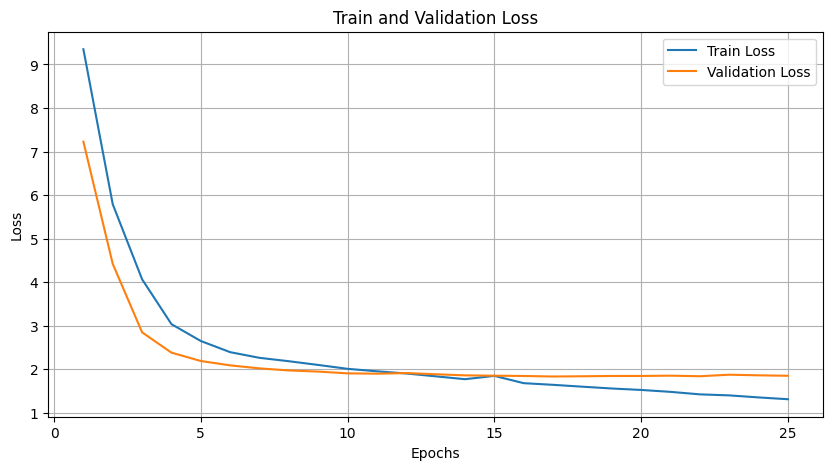

In [8]:
def plot_train_val_loss(train_losses, val_losses):
    epochs = len(train_losses)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()
    plt.grid(True)


    plt.show()

plot_train_val_loss(train_losses, val_losses)

In [9]:
def tester_function(model_path, test_df_path, d_test_path, o_test_path, image_dir, output_file="test_predictions.tsv"):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    with open(d_test_path, "rb") as f:
        d_test = pickle.load(f)
    with open(o_test_path, "rb") as f:
        o_test = pickle.load(f)

    df_test = pd.read_csv(test_df_path, sep="\t")

    test_dataset = MOREPDataset(df_test, image_dir, d_test, o_test)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

    model = MYTURBOModel().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    predictions = []
    references = []

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    smooth_fn = SmoothingFunction().method4

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Running Inference on Test Set"):
            batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
            pred_texts = model.generate(batch)
            tgt_texts = batch["explanation"]

            predictions.extend(pred_texts)
            references.extend(tgt_texts)

    rouge1, rouge2, rougeL = [], [], []
    bleu1, bleu2, bleu3, bleu4 = [], [], [], []
    meteor = []

    for pred, ref in zip(predictions, references):
        scores = scorer.score(ref, pred)
        rouge1.append(scores["rouge1"].fmeasure)
        rouge2.append(scores["rouge2"].fmeasure)
        rougeL.append(scores["rougeL"].fmeasure)

        ref_tokens = ref.split()
        pred_tokens = pred.split()

        bleu1.append(sentence_bleu([ref_tokens], pred_tokens, weights=(1, 0, 0, 0), smoothing_function=smooth_fn))
        bleu2.append(sentence_bleu([ref_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth_fn))
        bleu3.append(sentence_bleu([ref_tokens], pred_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth_fn))
        bleu4.append(sentence_bleu([ref_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth_fn))

        meteor.append(meteor_score([ref_tokens], pred_tokens))

    P, R, F1 = bert_score.score(predictions, references, lang="en", verbose=False)
    bertscore_avg = F1.mean().item()

    print("\nTest Set Evaluation Metrics:")
    print(f"ROUGE-1: {sum(rouge1)/len(rouge1):.4f}")
    print(f"ROUGE-2: {sum(rouge2)/len(rouge2):.4f}")
    print(f"ROUGE-L: {sum(rougeL)/len(rougeL):.4f}")
    print(f"BLEU-1:  {sum(bleu1)/len(bleu1):.4f}")
    print(f"BLEU-2:  {sum(bleu2)/len(bleu2):.4f}")
    print(f"BLEU-3:  {sum(bleu3)/len(bleu3):.4f}")
    print(f"BLEU-4:  {sum(bleu4)/len(bleu4):.4f}")
    print(f"METEOR:  {sum(meteor)/len(meteor):.4f}")
    print(f"BERTScore (F1): {bertscore_avg:.4f}")

    df_output = pd.DataFrame({
        "id": df_test["pid"],
        "prediction": predictions,
        "reference": references
    })
    df_output.to_csv(output_file, sep="\t", index=False)
    print(f"\n Predictions saved to {output_file}")

tester_function(
    model_path="/kaggle/working/checkpoints/best_model.pt",
    test_df_path="/kaggle/working/MorePLUS/val_df.tsv",
    d_test_path="/kaggle/working/MorePLUS/D_val.pkl",
    o_test_path="/kaggle/working/MorePLUS/O_val.pkl",
    image_dir="/kaggle/working/MorePLUS/images"
)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Running Inference on Test Set: 100%|██████████| 22/22 [00:13<00:00,  1.69it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Test Set Evaluation Metrics:
ROUGE-1: 0.2659
ROUGE-2: 0.0964
ROUGE-L: 0.2380
BLEU-1:  0.1484
BLEU-2:  0.0924
BLEU-3:  0.0682
BLEU-4:  0.0523
METEOR:  0.1413
BERTScore (F1): 0.8782

 Predictions saved to test_predictions.tsv
